In [95]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as p9
import anndata
import scanpy as sc
import scvi
import seaborn as sns
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scipy.sparse as sp # for sparse matrix


In [96]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()
%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [97]:
adata = sc.read_h5ad('blinded-epithelial-subtype-anndata.h5ad')
bdata = adata
bdata.X = adata.layers["matrix"]
print(bdata)

AnnData object with n_obs × n_vars = 24469 × 4148
    obs: 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'dataset', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'sample description', 'patient', 'blinded_subtype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Control_epi_anno_colors_lung', 'Control_epi_anno_lung_colors', 'Control_epi_anno_nasal_colors', 'Control_major_anno_colors', 'dendrogram_leiden_0.1', 'eCRSwNP_epi_anno_colors_lung', 'eCRSwNP_epi_anno_lung_colors', 'eCRSwNP_epi_anno_nasal_colors', 'eCRSwNP_major_anno_colors', 'epi_anno_colors', 'epi_anno_lung_colors', 'epi_anno_nasal_colors', 'hvg', 'leiden', 'leiden_0.1_colors', 'leiden_0.2_colors', 'leiden_0.3

In [98]:
def convert_and_clean_data(X, dtype=np.float32):
    """
    Convert data to specified dtype and clean special values
    
    Parameters:
    -----------
    X : array-like
        Input data matrix
    dtype : numpy dtype, optional
        Target data type (default: float32)
    
    Returns:
    --------
    Cleaned and converted matrix
    """
    # Convert to dense if sparse
    if sp.issparse(X):
        X = X.toarray()
    
    # Convert to specified dtype
    X = X.astype(dtype, copy=False)
    
    # Replace inf and nan
    X = np.nan_to_num(X, 
                      nan=0.0, 
                      posinf=np.finfo(dtype).max, 
                      neginf=np.finfo(dtype).min)
    
    return X

In [99]:
def prepare_anndata_for_deeplearning(adata, 
                                     layer='spliced',
                                     n_top_genes=2000,
                                     test_size=0.2,
                                     random_state=42):
    """
    Robust preprocessing for AnnData with careful data type handling
    """
    # Create a copy to avoid modifying original data
    adata_proc = adata.copy()
    
    # Convert and clean the data matrix
    X = convert_and_clean_data(adata_proc.layers[layer], dtype=np.float32)
    
    # Temporary AnnData with cleaned data
    temp_adata = anndata.AnnData(X)
    
    # Normalize 
    sc.pp.normalize_total(temp_adata, target_sum=1e4)
    sc.pp.log1p(temp_adata)
    
    # Select highly variable genes with robust method
    sc.pp.highly_variable_genes(temp_adata, 
                                 min_mean=0.0125, 
                                 max_mean=3, 
                                 min_disp=0.5,
                                 n_top_genes=n_top_genes)
    
    # Get selected genes
    selected_genes = temp_adata.var['highly_variable']
    
    # Extract selected features
    X_selected = temp_adata.X[:, selected_genes]
    
    # Scale the data
    scaler = StandardScaler(with_mean=False)
    X_scaled = scaler.fit_transform(X_selected)
    
    # Prepare target variable
    y = adata_proc.obs['blinded_subtype']
    y_encoded = pd.get_dummies(y).values
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded, 
        test_size=test_size, 
        random_state=random_state, 
        stratify=y_encoded
    )
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_train_tensor = torch.FloatTensor(y_train)
    y_test_tensor = torch.FloatTensor(y_test)
    
    return {
        'X_train': X_train_tensor,
        'X_test': X_test_tensor,
        'y_train': y_train_tensor,
        'y_test': y_test_tensor,
        'n_features': X_train.shape[1],
        'n_classes': y_encoded.shape[1],
        'scaler': scaler,
        'feature_names': adata_proc.var_names[selected_genes].tolist()
    }


In [100]:
# Comprehensive data type and quality diagnostics
def diagnose_data_details(adata, layer='spliced'):
    """
    Detailed data type and quality analysis
    """
    X = adata.layers[layer]
    
    print("Comprehensive Data Diagnostics:")
    print(f"Layer: {layer}")
    
    # Basic information
    print("\nBasic Information:")
    print(f"Original Data Type: {X.dtype}")
    
    # Sparsity check
    if sp.issparse(X):
        print("Matrix Type: Sparse")
        print(f"Sparse Format: {X.getformat()}")
        print(f"Shape: {X.shape}")
        print(f"Non-zero elements: {X.nnz}")
        print(f"Density: {X.nnz / (X.shape[0] * X.shape[1]):.4f}")
        X_dense = X.toarray()
    else:
        print("Matrix Type: Dense")
        X_dense = X
    
    # Detailed numerical analysis
    print("\nNumerical Properties:")
    print(f"Unique Data Types in Matrix: {np.unique(X_dense.dtype)}")
    print(f"Min value: {np.min(X_dense)}")
    print(f"Max value: {np.max(X_dense)}")
    print(f"Mean value: {np.mean(X_dense)}")
    print(f"Median value: {np.median(X_dense)}")
    
    # Value distribution
    print("\nValue Distribution:")
    unique_values = np.unique(X_dense)
    print(f"Number of unique values: {len(unique_values)}")
    print("First 10 unique values:", unique_values[:10])
    
    # Special value checks
    inf_count = np.sum(np.isinf(X_dense))
    nan_count = np.sum(np.isnan(X_dense))
    
    print(f"\nInfinite values: {inf_count}")
    print(f"NaN values: {nan_count}")
    
    return X_dense

In [101]:
X_diagnostic = diagnose_data_details(adata, layer='spliced')

Comprehensive Data Diagnostics:
Layer: spliced

Basic Information:
Original Data Type: uint16
Matrix Type: Sparse
Sparse Format: csr
Shape: (24469, 4148)
Non-zero elements: 3708929
Density: 0.0365

Numerical Properties:
Unique Data Types in Matrix: [dtype('uint16')]
Min value: 0
Max value: 10688
Mean value: 0.11950927379310913
Median value: 0.0

Value Distribution:
Number of unique values: 910
First 10 unique values: [0 1 2 3 4 5 6 7 8 9]

Infinite values: 0
NaN values: 0


In [102]:
#  Prepare data
prepared_data = prepare_anndata_for_deeplearning(adata, layer='spliced')

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts


In [108]:
print(prepared_data['X_train'].shape, prepared_data['X_test'].shape)
print(prepared_data['y_train'].shape, prepared_data['y_test'].shape)

torch.Size([19575, 2000]) torch.Size([4894, 2000])
torch.Size([19575, 9]) torch.Size([4894, 9])


In [110]:
X_train = prepared_data['X_train']
X_test = prepared_data['X_test']
y_train = prepared_data['y_train']
y_test = prepared_data['y_test']

In [116]:
#find the data type of the data
print(X_train.dtype, y_train.dtype)
print(X_test.dtype, y_test.dtype)


torch.float32 torch.float32
torch.float32 torch.float32


In [132]:
# Convert one-hot encoded labels to integer labels
y_train_int = torch.argmax(prepared_data['y_train'], dim=1).cpu().numpy()
# Convert PyTorch tensors to numpy arrays
X_train_numpy = prepared_data['X_train'].cpu().numpy()

In [133]:
# Create AnnData object
adata = sc.AnnData(X=X_train_numpy)
adata.obs['labels'] = y_train_int
adata.var_names = prepared_data['feature_names']

In [134]:
# Setup scVI - use the current recommended method
scvi.model.SCVI.setup_anndata(adata, categorical_covariate_keys=['labels'])

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?


In [135]:
# Initialize and train the model
model = scvi.model.SCVI(adata, n_layers=2, n_latent=10)
model.train(
    max_epochs=200, 
    check_val_every_n_epoch=5, 
    early_stopping=True
)

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/model/_scvi.py:168: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.

Epoch 1/200:   0%|          | 0/200 [00:00<?, ?it/s]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 2/200:   0%|          | 1/200 [00:02<07:22,  2.22s/it, v_num=1, train_loss_step=447, train_loss_epoch=541]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 3/200:   1%|          | 2/200 [00:04<08:06,  2.46s/it, v_num=1, train_loss_step=459, train_loss_epoch=459]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 4/200:   2%|▏         | 3/200 [00:07<07:59,  2.43s/it, v_num=1, train_loss_step=404, train_loss_epoch=434]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 5/200:   2%|▏         | 4/200 [00:09<07:39,  2.34s/it, v_num=1, train_loss_step=402, train_loss_epoch=418]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 6/200:   2%|▎         | 5/200 [00:11<07:26,  2.29s/it, v_num=1, train_loss_step=420, train_loss_epoch=405]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 7/200:   3%|▎         | 6/200 [00:13<07:18,  2.26s/it, v_num=1, train_loss_step=395, train_loss_epoch=394]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 8/200:   4%|▎         | 7/200 [00:16<07:11,  2.24s/it, v_num=1, train_loss_step=380, train_loss_epoch=384]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 9/200:   4%|▍         | 8/200 [00:18<07:07,  2.23s/it, v_num=1, train_loss_step=415, train_loss_epoch=375]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 10/200:   4%|▍         | 9/200 [00:20<07:03,  2.22s/it, v_num=1, train_loss_step=353, train_loss_epoch=368]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 11/200:   5%|▌         | 10/200 [00:22<07:00,  2.21s/it, v_num=1, train_loss_step=362, train_loss_epoch=361]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 12/200:   6%|▌         | 11/200 [00:24<06:58,  2.21s/it, v_num=1, train_loss_step=375, train_loss_epoch=355]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 13/200:   6%|▌         | 12/200 [00:27<06:53,  2.20s/it, v_num=1, train_loss_step=366, train_loss_epoch=350]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 14/200:   6%|▋         | 13/200 [00:29<06:49,  2.19s/it, v_num=1, train_loss_step=325, train_loss_epoch=345]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 15/200:   7%|▋         | 14/200 [00:31<06:45,  2.18s/it, v_num=1, train_loss_step=342, train_loss_epoch=340]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 16/200:   8%|▊         | 15/200 [00:33<07:08,  2.32s/it, v_num=1, train_loss_step=293, train_loss_epoch=336]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 17/200:   8%|▊         | 16/200 [00:36<07:26,  2.43s/it, v_num=1, train_loss_step=344, train_loss_epoch=332]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 18/200:   8%|▊         | 17/200 [00:39<07:37,  2.50s/it, v_num=1, train_loss_step=340, train_loss_epoch=328]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 19/200:   9%|▉         | 18/200 [00:42<07:45,  2.55s/it, v_num=1, train_loss_step=329, train_loss_epoch=324]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 20/200:  10%|▉         | 19/200 [00:44<07:41,  2.55s/it, v_num=1, train_loss_step=298, train_loss_epoch=321]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 21/200:  10%|█         | 20/200 [00:46<07:19,  2.44s/it, v_num=1, train_loss_step=304, train_loss_epoch=318]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 22/200:  10%|█         | 21/200 [00:48<07:02,  2.36s/it, v_num=1, train_loss_step=316, train_loss_epoch=316]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 23/200:  11%|█         | 22/200 [00:51<06:53,  2.32s/it, v_num=1, train_loss_step=306, train_loss_epoch=313]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 24/200:  12%|█▏        | 23/200 [00:53<06:43,  2.28s/it, v_num=1, train_loss_step=297, train_loss_epoch=310]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 25/200:  12%|█▏        | 24/200 [00:55<06:36,  2.25s/it, v_num=1, train_loss_step=312, train_loss_epoch=308]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 26/200:  12%|█▎        | 25/200 [00:57<06:31,  2.24s/it, v_num=1, train_loss_step=312, train_loss_epoch=306]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 27/200:  13%|█▎        | 26/200 [00:59<06:26,  2.22s/it, v_num=1, train_loss_step=302, train_loss_epoch=304]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 28/200:  14%|█▎        | 27/200 [01:02<06:21,  2.20s/it, v_num=1, train_loss_step=337, train_loss_epoch=302]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 29/200:  14%|█▍        | 28/200 [01:04<06:19,  2.20s/it, v_num=1, train_loss_step=292, train_loss_epoch=301]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 30/200:  14%|█▍        | 29/200 [01:06<06:21,  2.23s/it, v_num=1, train_loss_step=285, train_loss_epoch=299]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 31/200:  15%|█▌        | 30/200 [01:09<06:41,  2.36s/it, v_num=1, train_loss_step=290, train_loss_epoch=297]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 32/200:  16%|█▌        | 31/200 [01:11<06:56,  2.46s/it, v_num=1, train_loss_step=274, train_loss_epoch=296]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 33/200:  16%|█▌        | 32/200 [01:14<07:04,  2.53s/it, v_num=1, train_loss_step=315, train_loss_epoch=295]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 34/200:  16%|█▋        | 33/200 [01:17<07:09,  2.57s/it, v_num=1, train_loss_step=292, train_loss_epoch=294]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 35/200:  17%|█▋        | 34/200 [01:19<06:53,  2.49s/it, v_num=1, train_loss_step=313, train_loss_epoch=292]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 36/200:  18%|█▊        | 35/200 [01:21<06:41,  2.43s/it, v_num=1, train_loss_step=322, train_loss_epoch=291]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 37/200:  18%|█▊        | 36/200 [01:24<06:33,  2.40s/it, v_num=1, train_loss_step=301, train_loss_epoch=290]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 38/200:  18%|█▊        | 37/200 [01:26<06:22,  2.35s/it, v_num=1, train_loss_step=310, train_loss_epoch=290]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 39/200:  19%|█▉        | 38/200 [01:29<06:37,  2.45s/it, v_num=1, train_loss_step=288, train_loss_epoch=289]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 40/200:  20%|█▉        | 39/200 [01:31<06:46,  2.52s/it, v_num=1, train_loss_step=302, train_loss_epoch=288]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 41/200:  20%|██        | 40/200 [01:34<06:51,  2.57s/it, v_num=1, train_loss_step=304, train_loss_epoch=287]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 42/200:  20%|██        | 41/200 [01:37<06:54,  2.60s/it, v_num=1, train_loss_step=301, train_loss_epoch=286]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 43/200:  21%|██        | 42/200 [01:39<06:55,  2.63s/it, v_num=1, train_loss_step=284, train_loss_epoch=286]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 44/200:  22%|██▏       | 43/200 [01:42<06:55,  2.64s/it, v_num=1, train_loss_step=250, train_loss_epoch=285]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 45/200:  22%|██▏       | 44/200 [01:45<06:55,  2.66s/it, v_num=1, train_loss_step=288, train_loss_epoch=284]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 46/200:  22%|██▎       | 45/200 [01:47<06:53,  2.67s/it, v_num=1, train_loss_step=273, train_loss_epoch=284]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 47/200:  23%|██▎       | 46/200 [01:50<06:50,  2.67s/it, v_num=1, train_loss_step=272, train_loss_epoch=283]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 48/200:  24%|██▎       | 47/200 [01:53<06:48,  2.67s/it, v_num=1, train_loss_step=275, train_loss_epoch=283]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 49/200:  24%|██▍       | 48/200 [01:55<06:46,  2.68s/it, v_num=1, train_loss_step=293, train_loss_epoch=282]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 50/200:  24%|██▍       | 49/200 [01:58<06:44,  2.68s/it, v_num=1, train_loss_step=259, train_loss_epoch=282]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 51/200:  25%|██▌       | 50/200 [02:01<06:41,  2.68s/it, v_num=1, train_loss_step=259, train_loss_epoch=282]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 52/200:  26%|██▌       | 51/200 [02:04<06:40,  2.69s/it, v_num=1, train_loss_step=300, train_loss_epoch=281]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 53/200:  26%|██▌       | 52/200 [02:06<06:37,  2.69s/it, v_num=1, train_loss_step=237, train_loss_epoch=281]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 54/200:  26%|██▋       | 53/200 [02:09<06:34,  2.68s/it, v_num=1, train_loss_step=287, train_loss_epoch=280]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 55/200:  27%|██▋       | 54/200 [02:12<06:33,  2.69s/it, v_num=1, train_loss_step=281, train_loss_epoch=280]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 56/200:  28%|██▊       | 55/200 [02:14<06:30,  2.69s/it, v_num=1, train_loss_step=260, train_loss_epoch=280]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 57/200:  28%|██▊       | 56/200 [02:17<06:26,  2.68s/it, v_num=1, train_loss_step=280, train_loss_epoch=279]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 58/200:  28%|██▊       | 57/200 [02:20<06:23,  2.68s/it, v_num=1, train_loss_step=323, train_loss_epoch=279]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 59/200:  29%|██▉       | 58/200 [02:22<06:20,  2.68s/it, v_num=1, train_loss_step=254, train_loss_epoch=279]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 60/200:  30%|██▉       | 59/200 [02:25<06:18,  2.69s/it, v_num=1, train_loss_step=292, train_loss_epoch=279]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 61/200:  30%|███       | 60/200 [02:28<06:16,  2.69s/it, v_num=1, train_loss_step=267, train_loss_epoch=278]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 62/200:  30%|███       | 61/200 [02:30<06:14,  2.69s/it, v_num=1, train_loss_step=253, train_loss_epoch=278]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 63/200:  31%|███       | 62/200 [02:33<06:12,  2.70s/it, v_num=1, train_loss_step=276, train_loss_epoch=278]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 64/200:  32%|███▏      | 63/200 [02:36<06:11,  2.71s/it, v_num=1, train_loss_step=291, train_loss_epoch=278]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 65/200:  32%|███▏      | 64/200 [02:39<06:07,  2.70s/it, v_num=1, train_loss_step=274, train_loss_epoch=277]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 66/200:  32%|███▎      | 65/200 [02:41<05:44,  2.55s/it, v_num=1, train_loss_step=237, train_loss_epoch=277]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 67/200:  33%|███▎      | 66/200 [02:43<05:32,  2.48s/it, v_num=1, train_loss_step=270, train_loss_epoch=277]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 68/200:  34%|███▎      | 67/200 [02:46<05:39,  2.55s/it, v_num=1, train_loss_step=288, train_loss_epoch=277]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 69/200:  34%|███▍      | 68/200 [02:48<05:11,  2.36s/it, v_num=1, train_loss_step=305, train_loss_epoch=277]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 70/200:  34%|███▍      | 69/200 [02:50<04:49,  2.21s/it, v_num=1, train_loss_step=286, train_loss_epoch=277]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 71/200:  35%|███▌      | 70/200 [02:51<04:34,  2.12s/it, v_num=1, train_loss_step=295, train_loss_epoch=276]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 72/200:  36%|███▌      | 71/200 [02:54<04:50,  2.25s/it, v_num=1, train_loss_step=288, train_loss_epoch=276]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 73/200:  36%|███▌      | 72/200 [02:57<05:05,  2.38s/it, v_num=1, train_loss_step=299, train_loss_epoch=276]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 74/200:  36%|███▋      | 73/200 [02:59<05:14,  2.48s/it, v_num=1, train_loss_step=277, train_loss_epoch=276]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 75/200:  37%|███▋      | 74/200 [03:02<05:19,  2.54s/it, v_num=1, train_loss_step=263, train_loss_epoch=276]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 76/200:  38%|███▊      | 75/200 [03:04<05:05,  2.44s/it, v_num=1, train_loss_step=274, train_loss_epoch=276]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 77/200:  38%|███▊      | 76/200 [03:06<04:52,  2.36s/it, v_num=1, train_loss_step=251, train_loss_epoch=276]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 78/200:  38%|███▊      | 77/200 [03:09<04:43,  2.30s/it, v_num=1, train_loss_step=293, train_loss_epoch=276]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 79/200:  39%|███▉      | 78/200 [03:11<04:35,  2.26s/it, v_num=1, train_loss_step=276, train_loss_epoch=275]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 80/200:  40%|███▉      | 79/200 [03:13<04:30,  2.24s/it, v_num=1, train_loss_step=310, train_loss_epoch=275]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 81/200:  40%|████      | 80/200 [03:15<04:26,  2.22s/it, v_num=1, train_loss_step=270, train_loss_epoch=275]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 82/200:  40%|████      | 81/200 [03:17<04:23,  2.22s/it, v_num=1, train_loss_step=307, train_loss_epoch=275]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 83/200:  41%|████      | 82/200 [03:20<04:21,  2.22s/it, v_num=1, train_loss_step=235, train_loss_epoch=275]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 84/200:  42%|████▏     | 83/200 [03:22<04:19,  2.22s/it, v_num=1, train_loss_step=279, train_loss_epoch=275]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 85/200:  42%|████▏     | 84/200 [03:24<04:16,  2.21s/it, v_num=1, train_loss_step=268, train_loss_epoch=275]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 86/200:  42%|████▎     | 85/200 [03:26<04:13,  2.21s/it, v_num=1, train_loss_step=278, train_loss_epoch=275]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 87/200:  43%|████▎     | 86/200 [03:28<04:12,  2.21s/it, v_num=1, train_loss_step=275, train_loss_epoch=275]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 88/200:  44%|████▎     | 87/200 [03:31<04:17,  2.28s/it, v_num=1, train_loss_step=284, train_loss_epoch=275]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 89/200:  44%|████▍     | 88/200 [03:34<04:29,  2.40s/it, v_num=1, train_loss_step=276, train_loss_epoch=275]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 90/200:  44%|████▍     | 89/200 [03:36<04:37,  2.50s/it, v_num=1, train_loss_step=244, train_loss_epoch=275]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 91/200:  45%|████▌     | 90/200 [03:39<04:27,  2.43s/it, v_num=1, train_loss_step=256, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 92/200:  46%|████▌     | 91/200 [03:41<04:20,  2.39s/it, v_num=1, train_loss_step=277, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 93/200:  46%|████▌     | 92/200 [03:43<04:14,  2.36s/it, v_num=1, train_loss_step=293, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 94/200:  46%|████▋     | 93/200 [03:45<04:11,  2.35s/it, v_num=1, train_loss_step=295, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 95/200:  47%|████▋     | 94/200 [03:48<04:06,  2.33s/it, v_num=1, train_loss_step=297, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 96/200:  48%|████▊     | 95/200 [03:50<04:02,  2.31s/it, v_num=1, train_loss_step=256, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 97/200:  48%|████▊     | 96/200 [03:52<03:59,  2.30s/it, v_num=1, train_loss_step=268, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 98/200:  48%|████▊     | 97/200 [03:55<03:56,  2.30s/it, v_num=1, train_loss_step=263, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 99/200:  49%|████▉     | 98/200 [03:57<03:52,  2.28s/it, v_num=1, train_loss_step=276, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 100/200:  50%|████▉     | 99/200 [03:59<03:47,  2.26s/it, v_num=1, train_loss_step=278, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 101/200:  50%|█████     | 100/200 [04:01<03:43,  2.24s/it, v_num=1, train_loss_step=278, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 102/200:  50%|█████     | 101/200 [04:03<03:40,  2.23s/it, v_num=1, train_loss_step=300, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 103/200:  51%|█████     | 102/200 [04:06<03:37,  2.22s/it, v_num=1, train_loss_step=260, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 104/200:  52%|█████▏    | 103/200 [04:08<03:34,  2.21s/it, v_num=1, train_loss_step=274, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 105/200:  52%|█████▏    | 104/200 [04:10<03:32,  2.21s/it, v_num=1, train_loss_step=285, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 106/200:  52%|█████▎    | 105/200 [04:12<03:36,  2.28s/it, v_num=1, train_loss_step=277, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 107/200:  53%|█████▎    | 106/200 [04:15<03:40,  2.35s/it, v_num=1, train_loss_step=283, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 108/200:  54%|█████▎    | 107/200 [04:17<03:34,  2.30s/it, v_num=1, train_loss_step=308, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 109/200:  54%|█████▍    | 108/200 [04:19<03:28,  2.27s/it, v_num=1, train_loss_step=313, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 110/200:  55%|█████▍    | 109/200 [04:22<03:26,  2.27s/it, v_num=1, train_loss_step=264, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 111/200:  55%|█████▌    | 110/200 [04:24<03:35,  2.39s/it, v_num=1, train_loss_step=259, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 112/200:  56%|█████▌    | 111/200 [04:27<03:40,  2.48s/it, v_num=1, train_loss_step=290, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 113/200:  56%|█████▌    | 112/200 [04:30<03:43,  2.54s/it, v_num=1, train_loss_step=296, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 114/200:  56%|█████▋    | 113/200 [04:32<03:45,  2.59s/it, v_num=1, train_loss_step=263, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 115/200:  57%|█████▋    | 114/200 [04:35<03:45,  2.62s/it, v_num=1, train_loss_step=266, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 116/200:  57%|█████▊    | 115/200 [04:38<03:44,  2.64s/it, v_num=1, train_loss_step=253, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 117/200:  58%|█████▊    | 116/200 [04:40<03:42,  2.65s/it, v_num=1, train_loss_step=264, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 118/200:  58%|█████▊    | 117/200 [04:43<03:28,  2.52s/it, v_num=1, train_loss_step=247, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 119/200:  59%|█████▉    | 118/200 [04:45<03:18,  2.42s/it, v_num=1, train_loss_step=283, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 120/200:  60%|█████▉    | 119/200 [04:47<03:10,  2.35s/it, v_num=1, train_loss_step=304, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 121/200:  60%|██████    | 120/200 [04:49<03:04,  2.31s/it, v_num=1, train_loss_step=271, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 122/200:  60%|██████    | 121/200 [04:51<02:59,  2.28s/it, v_num=1, train_loss_step=287, train_loss_epoch=273]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 123/200:  61%|██████    | 122/200 [04:54<02:55,  2.25s/it, v_num=1, train_loss_step=256, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 124/200:  62%|██████▏   | 123/200 [04:56<02:51,  2.23s/it, v_num=1, train_loss_step=283, train_loss_epoch=273]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 125/200:  62%|██████▏   | 124/200 [04:58<02:48,  2.22s/it, v_num=1, train_loss_step=274, train_loss_epoch=273]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 126/200:  62%|██████▎   | 125/200 [05:00<02:45,  2.21s/it, v_num=1, train_loss_step=277, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 127/200:  63%|██████▎   | 126/200 [05:02<02:42,  2.20s/it, v_num=1, train_loss_step=267, train_loss_epoch=273]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 128/200:  64%|██████▎   | 127/200 [05:05<02:40,  2.19s/it, v_num=1, train_loss_step=269, train_loss_epoch=273]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 129/200:  64%|██████▍   | 128/200 [05:07<02:37,  2.19s/it, v_num=1, train_loss_step=260, train_loss_epoch=273]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 130/200:  64%|██████▍   | 129/200 [05:09<02:35,  2.19s/it, v_num=1, train_loss_step=253, train_loss_epoch=273]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 131/200:  65%|██████▌   | 130/200 [05:11<02:32,  2.18s/it, v_num=1, train_loss_step=273, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 132/200:  66%|██████▌   | 131/200 [05:13<02:30,  2.18s/it, v_num=1, train_loss_step=276, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 133/200:  66%|██████▌   | 132/200 [05:16<02:32,  2.24s/it, v_num=1, train_loss_step=265, train_loss_epoch=273]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 134/200:  66%|██████▋   | 133/200 [05:18<02:39,  2.37s/it, v_num=1, train_loss_step=262, train_loss_epoch=273]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 135/200:  67%|██████▋   | 134/200 [05:21<02:42,  2.46s/it, v_num=1, train_loss_step=241, train_loss_epoch=273]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 136/200:  68%|██████▊   | 135/200 [05:23<02:36,  2.41s/it, v_num=1, train_loss_step=254, train_loss_epoch=273]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 137/200:  68%|██████▊   | 136/200 [05:26<02:40,  2.50s/it, v_num=1, train_loss_step=271, train_loss_epoch=273]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 138/200:  68%|██████▊   | 137/200 [05:29<02:41,  2.56s/it, v_num=1, train_loss_step=251, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 139/200:  69%|██████▉   | 138/200 [05:31<02:41,  2.60s/it, v_num=1, train_loss_step=256, train_loss_epoch=273]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 140/200:  70%|██████▉   | 139/200 [05:34<02:40,  2.63s/it, v_num=1, train_loss_step=257, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 141/200:  70%|███████   | 140/200 [05:37<02:38,  2.64s/it, v_num=1, train_loss_step=270, train_loss_epoch=273]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 142/200:  70%|███████   | 141/200 [05:39<02:36,  2.66s/it, v_num=1, train_loss_step=262, train_loss_epoch=273]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 143/200:  71%|███████   | 142/200 [05:42<02:34,  2.66s/it, v_num=1, train_loss_step=272, train_loss_epoch=273]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 144/200:  72%|███████▏  | 143/200 [05:45<02:32,  2.67s/it, v_num=1, train_loss_step=282, train_loss_epoch=273]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 145/200:  72%|███████▏  | 144/200 [05:48<02:29,  2.67s/it, v_num=1, train_loss_step=285, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 146/200:  72%|███████▎  | 145/200 [05:50<02:19,  2.53s/it, v_num=1, train_loss_step=245, train_loss_epoch=273]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 147/200:  73%|███████▎  | 146/200 [05:52<02:11,  2.43s/it, v_num=1, train_loss_step=239, train_loss_epoch=273]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 148/200:  74%|███████▎  | 147/200 [05:54<02:06,  2.39s/it, v_num=1, train_loss_step=270, train_loss_epoch=273]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 149/200:  74%|███████▍  | 148/200 [05:56<02:01,  2.34s/it, v_num=1, train_loss_step=282, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 150/200:  74%|███████▍  | 149/200 [05:59<01:57,  2.30s/it, v_num=1, train_loss_step=274, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 151/200:  75%|███████▌  | 150/200 [06:01<01:53,  2.27s/it, v_num=1, train_loss_step=271, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 152/200:  76%|███████▌  | 151/200 [06:03<01:50,  2.26s/it, v_num=1, train_loss_step=306, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 153/200:  76%|███████▌  | 152/200 [06:05<01:47,  2.24s/it, v_num=1, train_loss_step=257, train_loss_epoch=273]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 154/200:  76%|███████▋  | 153/200 [06:07<01:45,  2.24s/it, v_num=1, train_loss_step=266, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 155/200:  77%|███████▋  | 154/200 [06:10<01:42,  2.24s/it, v_num=1, train_loss_step=294, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 156/200:  78%|███████▊  | 155/200 [06:12<01:40,  2.23s/it, v_num=1, train_loss_step=265, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 157/200:  78%|███████▊  | 156/200 [06:14<01:37,  2.22s/it, v_num=1, train_loss_step=248, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 158/200:  78%|███████▊  | 157/200 [06:16<01:35,  2.23s/it, v_num=1, train_loss_step=256, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 159/200:  79%|███████▉  | 158/200 [06:19<01:33,  2.22s/it, v_num=1, train_loss_step=276, train_loss_epoch=273]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 160/200:  80%|███████▉  | 159/200 [06:21<01:31,  2.22s/it, v_num=1, train_loss_step=244, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 161/200:  80%|████████  | 160/200 [06:23<01:28,  2.22s/it, v_num=1, train_loss_step=272, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 162/200:  80%|████████  | 161/200 [06:25<01:26,  2.21s/it, v_num=1, train_loss_step=280, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 163/200:  81%|████████  | 162/200 [06:27<01:23,  2.21s/it, v_num=1, train_loss_step=278, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 164/200:  82%|████████▏ | 163/200 [06:30<01:21,  2.21s/it, v_num=1, train_loss_step=296, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 165/200:  82%|████████▏ | 164/200 [06:32<01:20,  2.22s/it, v_num=1, train_loss_step=235, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 166/200:  82%|████████▎ | 165/200 [06:34<01:17,  2.22s/it, v_num=1, train_loss_step=276, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 167/200:  83%|████████▎ | 166/200 [06:36<01:15,  2.22s/it, v_num=1, train_loss_step=278, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 168/200:  84%|████████▎ | 167/200 [06:39<01:13,  2.22s/it, v_num=1, train_loss_step=316, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 169/200:  84%|████████▍ | 168/200 [06:41<01:10,  2.21s/it, v_num=1, train_loss_step=289, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 170/200:  84%|████████▍ | 169/200 [06:43<01:08,  2.21s/it, v_num=1, train_loss_step=280, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 171/200:  85%|████████▌ | 170/200 [06:45<01:06,  2.21s/it, v_num=1, train_loss_step=277, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 172/200:  86%|████████▌ | 171/200 [06:47<01:04,  2.21s/it, v_num=1, train_loss_step=251, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 173/200:  86%|████████▌ | 172/200 [06:50<01:02,  2.22s/it, v_num=1, train_loss_step=292, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 174/200:  86%|████████▋ | 173/200 [06:52<00:59,  2.22s/it, v_num=1, train_loss_step=286, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 175/200:  87%|████████▋ | 174/200 [06:54<00:57,  2.22s/it, v_num=1, train_loss_step=272, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 176/200:  88%|████████▊ | 175/200 [06:56<00:55,  2.22s/it, v_num=1, train_loss_step=281, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 177/200:  88%|████████▊ | 176/200 [06:58<00:53,  2.21s/it, v_num=1, train_loss_step=258, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 178/200:  88%|████████▊ | 177/200 [07:01<00:50,  2.21s/it, v_num=1, train_loss_step=280, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 179/200:  89%|████████▉ | 178/200 [07:03<00:48,  2.20s/it, v_num=1, train_loss_step=279, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 180/200:  90%|████████▉ | 179/200 [07:05<00:48,  2.30s/it, v_num=1, train_loss_step=274, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 181/200:  90%|█████████ | 180/200 [07:08<00:48,  2.42s/it, v_num=1, train_loss_step=305, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 182/200:  90%|█████████ | 181/200 [07:11<00:47,  2.50s/it, v_num=1, train_loss_step=277, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 183/200:  91%|█████████ | 182/200 [07:13<00:46,  2.56s/it, v_num=1, train_loss_step=271, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 184/200:  92%|█████████▏| 183/200 [07:16<00:44,  2.60s/it, v_num=1, train_loss_step=278, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 185/200:  92%|█████████▏| 184/200 [07:19<00:41,  2.57s/it, v_num=1, train_loss_step=245, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 186/200:  92%|█████████▎| 185/200 [07:21<00:36,  2.46s/it, v_num=1, train_loss_step=272, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 187/200:  93%|█████████▎| 186/200 [07:23<00:33,  2.37s/it, v_num=1, train_loss_step=239, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 188/200:  94%|█████████▎| 187/200 [07:25<00:30,  2.33s/it, v_num=1, train_loss_step=262, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 189/200:  94%|█████████▍| 188/200 [07:27<00:27,  2.30s/it, v_num=1, train_loss_step=259, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 190/200:  94%|█████████▍| 189/200 [07:30<00:24,  2.27s/it, v_num=1, train_loss_step=277, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 191/200:  95%|█████████▌| 190/200 [07:32<00:22,  2.27s/it, v_num=1, train_loss_step=268, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 192/200:  96%|█████████▌| 191/200 [07:34<00:20,  2.25s/it, v_num=1, train_loss_step=250, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 193/200:  96%|█████████▌| 192/200 [07:36<00:17,  2.24s/it, v_num=1, train_loss_step=314, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 194/200:  96%|█████████▋| 193/200 [07:39<00:15,  2.23s/it, v_num=1, train_loss_step=260, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 195/200:  97%|█████████▋| 194/200 [07:41<00:13,  2.22s/it, v_num=1, train_loss_step=254, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 196/200:  98%|█████████▊| 195/200 [07:43<00:11,  2.21s/it, v_num=1, train_loss_step=295, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 197/200:  98%|█████████▊| 196/200 [07:45<00:08,  2.21s/it, v_num=1, train_loss_step=254, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 198/200:  98%|█████████▊| 197/200 [07:48<00:06,  2.27s/it, v_num=1, train_loss_step=262, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 199/200:  99%|█████████▉| 198/200 [07:50<00:04,  2.40s/it, v_num=1, train_loss_step=274, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 200/200: 100%|█████████▉| 199/200 [07:53<00:02,  2.49s/it, v_num=1, train_loss_step=308, train_loss_epoch=274]

/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
/home/dhakal/anaconda3/envs/URT_NSCL/lib/python3.12/site-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution


Epoch 200/200: 100%|██████████| 200/200 [07:56<00:00,  2.55s/it, v_num=1, train_loss_step=290, train_loss_epoch=274]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [07:56<00:00,  2.38s/it, v_num=1, train_loss_step=290, train_loss_epoch=274]


In [150]:
# Visualization functions
def plot_training_history(model):
    """Plot the training loss history"""
    plt.figure(figsize=(10, 6))
    plt.plot(model.history_['elbo_train'], label='Training ELBO')
    plt.plot(model.history_['elbo_validation'], label='Validation ELBO')
    plt.title('Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Evidence Lower Bound (ELBO)')
    plt.legend()
    plt.tight_layout()
    plt.show()

def visualize_latent_space(model, adata):
    """Visualize the latent space using UMAP"""
    # Get latent representation
    latent = model.get_latent_representation()
    
    # Create AnnData with latent representation
    latent_adata = sc.AnnData(latent)
    latent_adata.obs['labels'] = adata.obs['labels']
    
    # Perform UMAP
    sc.pp.neighbors(latent_adata)
    sc.tl.umap(latent_adata)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sc.pl.umap(latent_adata, color='labels', palette='tab10', title='Latent Space Visualization')
    plt.tight_layout()
    plt.show()



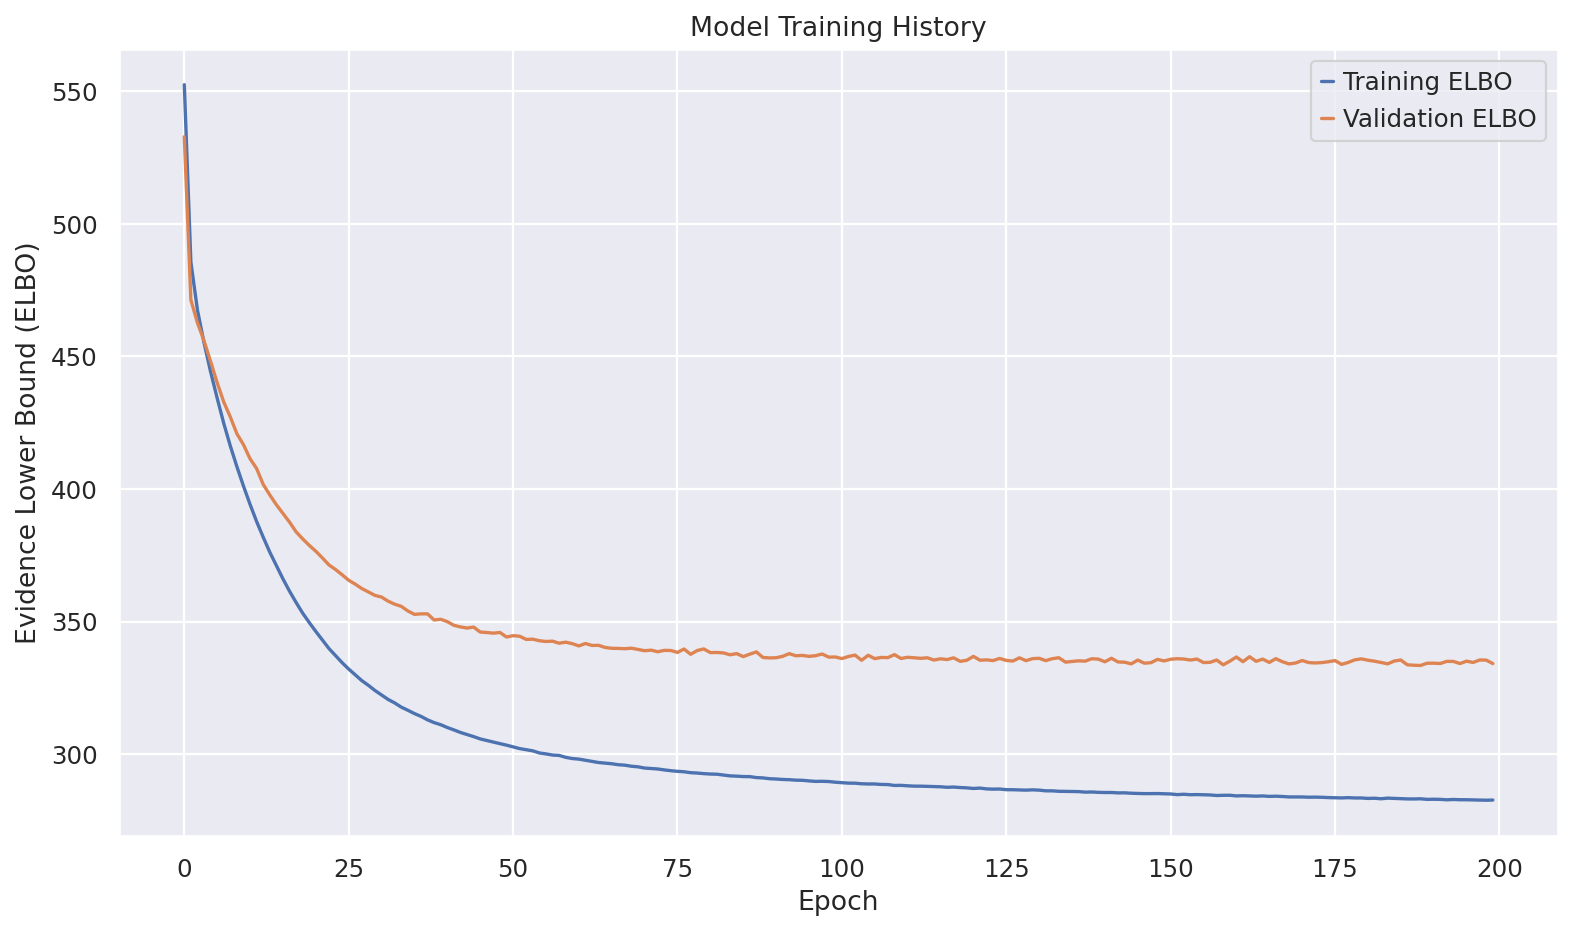

<Figure size 800x640 with 0 Axes>

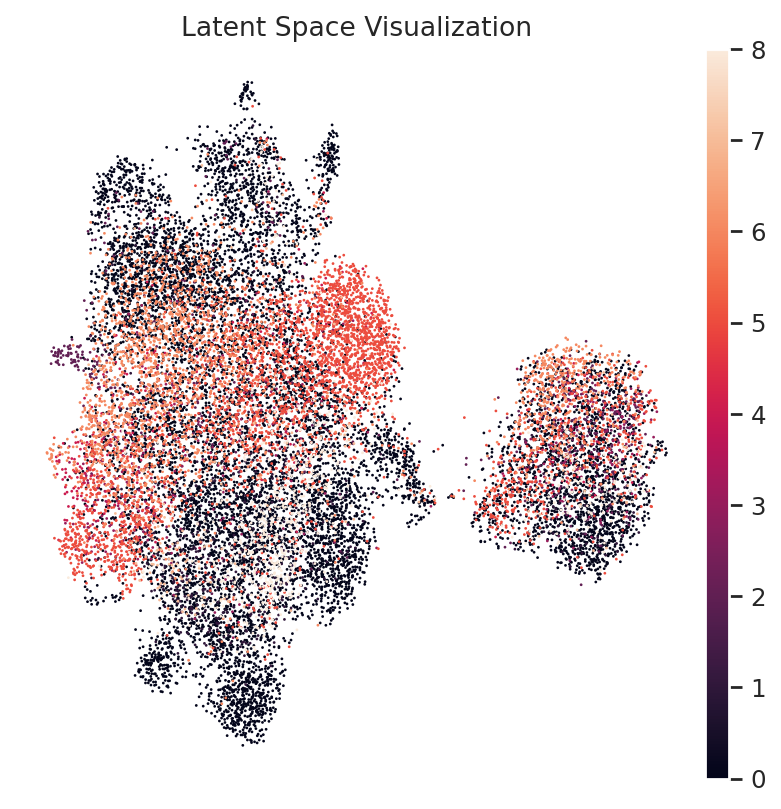

<Figure size 480x480 with 0 Axes>

In [152]:
# Generate visualizations
plot_training_history(model)
visualize_latent_space(model, adata)


In [142]:
def identify_biomarkers(model, adata, top_n=20):
    """
    Identify top features that have high impact on model performance
    
    Parameters:
    - model: Trained scVI model
    - adata: AnnData object
    - top_n: Number of top features to return
    
    Returns:
    - List of top biomarkers with their importance scores
    """
    # Compute feature importance using original data
    # Use mean absolute value across samples for each feature
    feature_importance = {}
    for i, feature in enumerate(adata.var_names):
        # Compute mean absolute value of the feature
        feature_imp = np.mean(np.abs(adata.X[:, i]))
        feature_importance[feature] = feature_imp
    
    # Sort features by importance
    sorted_features = sorted(
        feature_importance.items(), 
        key=lambda x: x[1], 
        reverse=True
    )
    
    # Select top N biomarkers
    top_biomarkers = sorted_features[:top_n]
    
    return top_biomarkers

In [143]:
# Identify and visualize biomarkers
top_biomarkers = identify_biomarkers(model, adata)

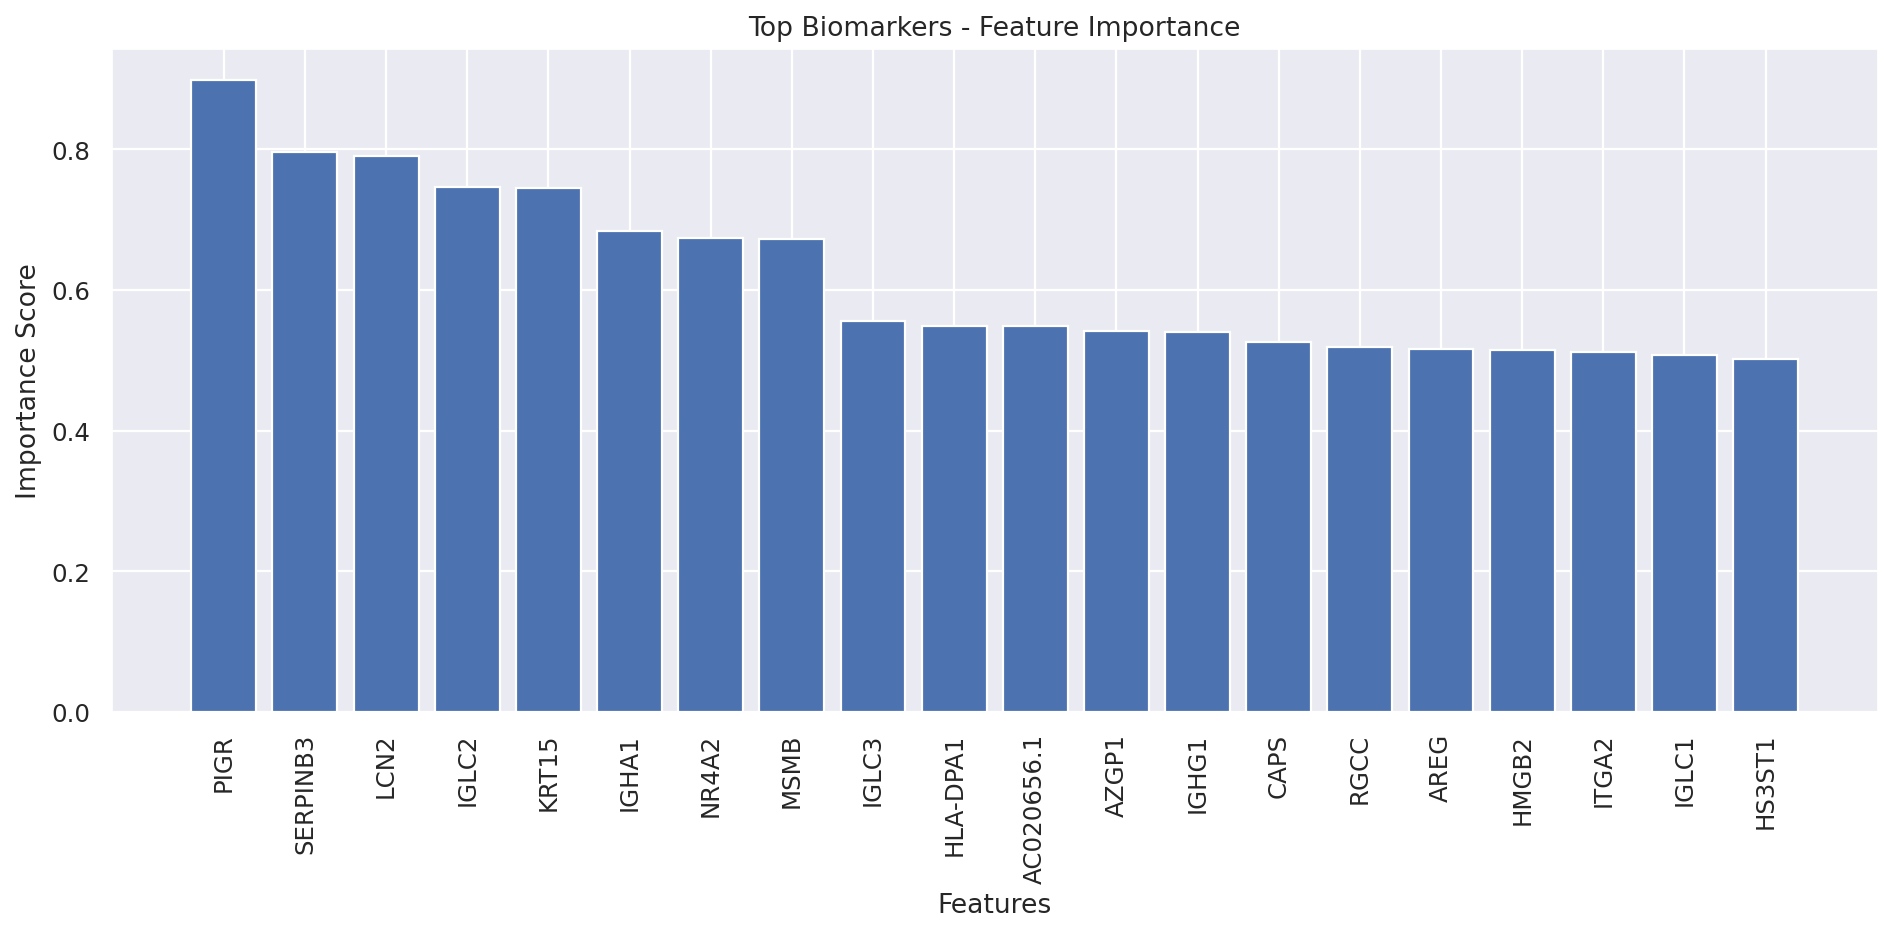

In [144]:
# Visualization of top biomarkers
plt.figure(figsize=(12, 6))
features, scores = zip(*top_biomarkers)
plt.bar(features, scores)
plt.title('Top Biomarkers - Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [145]:
# Print out top biomarkers with details
print("Top Biomarkers:")
for feature, importance in top_biomarkers:
    print(f"Feature: {feature}, Importance Score: {importance}")

Top Biomarkers:
Feature: PIGR, Importance Score: 0.8986976146697998
Feature: SERPINB3, Importance Score: 0.7961181998252869
Feature: LCN2, Importance Score: 0.7902708649635315
Feature: IGLC2, Importance Score: 0.7469735741615295
Feature: KRT15, Importance Score: 0.74457186460495
Feature: IGHA1, Importance Score: 0.6841153502464294
Feature: NR4A2, Importance Score: 0.6741598844528198
Feature: MSMB, Importance Score: 0.6720455884933472
Feature: IGLC3, Importance Score: 0.556083083152771
Feature: HLA-DPA1, Importance Score: 0.5493205785751343
Feature: AC020656.1, Importance Score: 0.5491755604743958
Feature: AZGP1, Importance Score: 0.541240930557251
Feature: IGHG1, Importance Score: 0.5401562452316284
Feature: CAPS, Importance Score: 0.5254359841346741
Feature: RGCC, Importance Score: 0.5191946029663086
Feature: AREG, Importance Score: 0.5161718130111694
Feature: HMGB2, Importance Score: 0.5152133703231812
Feature: ITGA2, Importance Score: 0.5121330618858337
Feature: IGLC1, Importance Sc

In [146]:
# Additional analysis: Correlation with labels
def analyze_biomarker_label_correlation(adata, top_biomarkers):
    """
    Analyze correlation of top biomarkers with labels
    """
    correlation_results = []
    
    for feature, _ in top_biomarkers:
        # Get feature index
        feature_idx = np.where(adata.var_names == feature)[0][0]
        
        # Extract feature values
        feature_values = adata.X[:, feature_idx]
        
        # Compute correlation with labels
        for unique_label in np.unique(adata.obs['labels']):
            label_mask = (adata.obs['labels'] == unique_label)
            
            # Compute point-biserial correlation
            from scipy.stats import pointbiserialr
            try:
                correlation, p_value = pointbiserialr(label_mask, feature_values)
                correlation_results.append({
                    'Feature': feature,
                    'Label': unique_label,
                    'Correlation': correlation,
                    'P-value': p_value
                })
            except Exception as e:
                print(f"Error computing correlation for {feature}, label {unique_label}: {e}")
    
    return correlation_results

In [147]:
# Perform correlation analysis
biomarker_correlations = analyze_biomarker_label_correlation(adata, top_biomarkers)

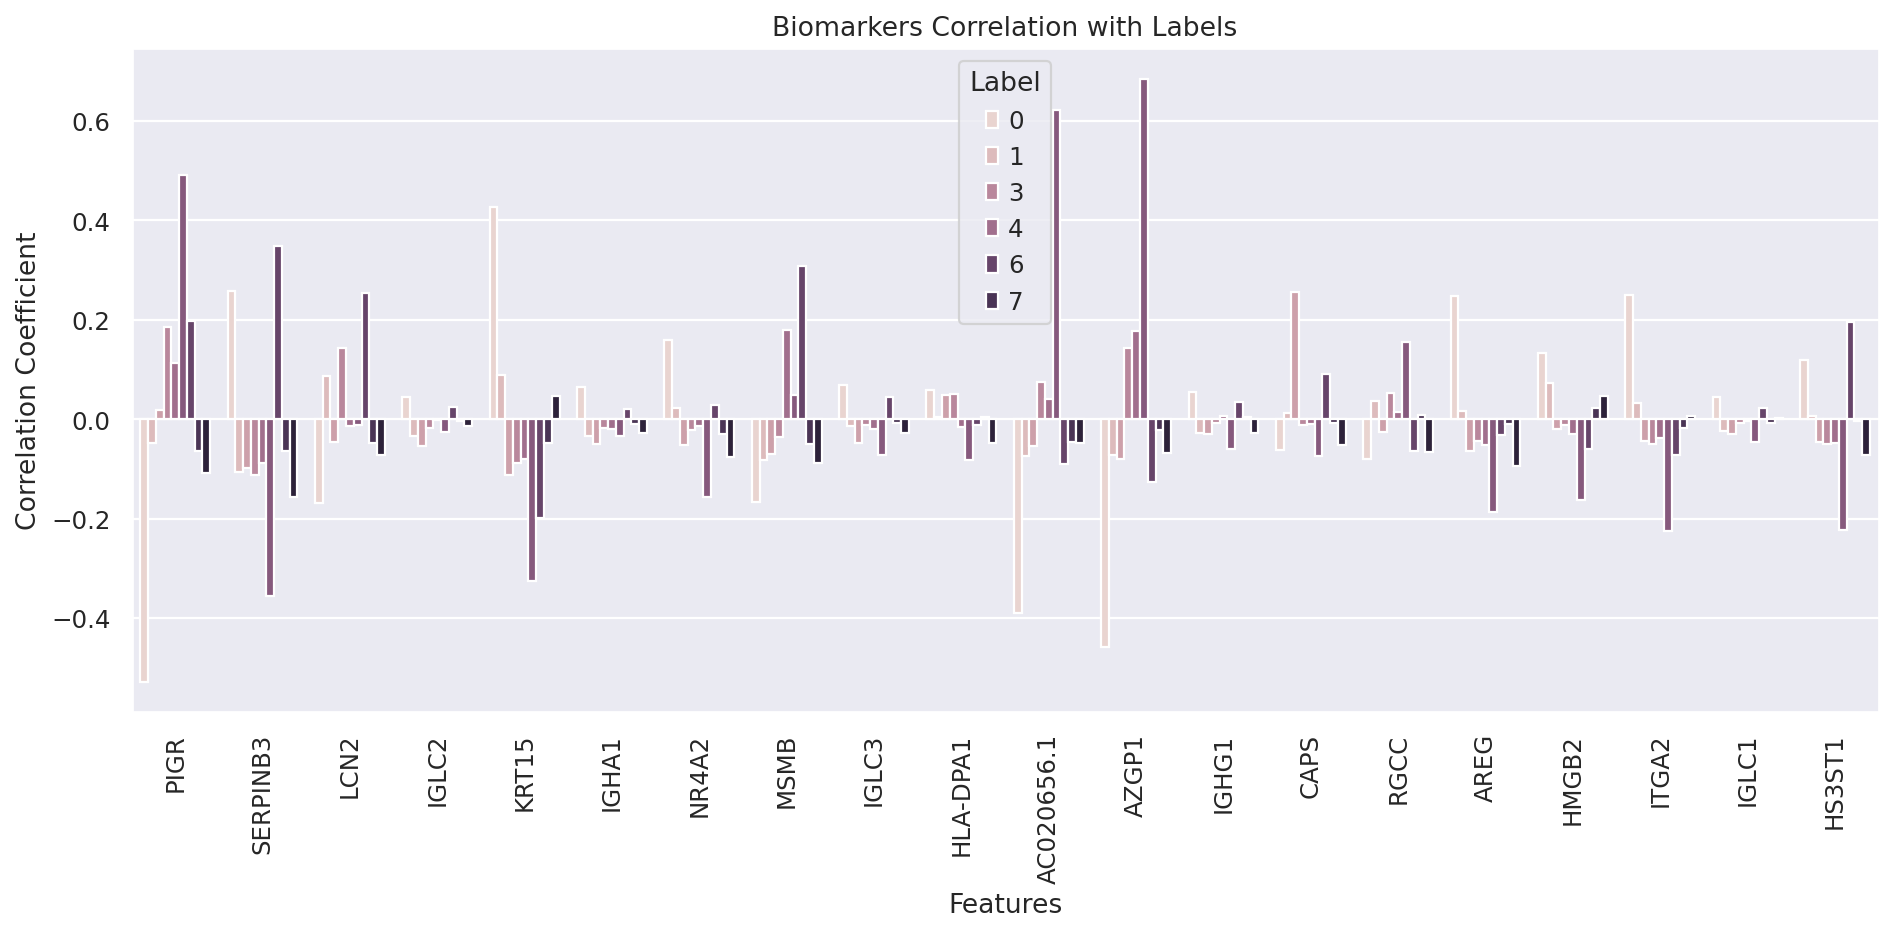

In [148]:
# Visualize correlations
plt.figure(figsize=(12, 6))
correlation_df = pd.DataFrame(biomarker_correlations)
sns.barplot(x='Feature', y='Correlation', hue='Label', data=correlation_df)
plt.title('Biomarkers Correlation with Labels')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [149]:
# Print correlation details
print("\nBiomarker-Label Correlations:")
for result in biomarker_correlations:
    print(f"Feature: {result['Feature']}, Label: {result['Label']}, Correlation: {result['Correlation']:.4f}")


Biomarker-Label Correlations:
Feature: PIGR, Label: 0, Correlation: -0.5278
Feature: PIGR, Label: 1, Correlation: -0.0478
Feature: PIGR, Label: 2, Correlation: 0.0195
Feature: PIGR, Label: 3, Correlation: 0.1855
Feature: PIGR, Label: 4, Correlation: 0.1137
Feature: PIGR, Label: 5, Correlation: 0.4905
Feature: PIGR, Label: 6, Correlation: 0.1984
Feature: PIGR, Label: 7, Correlation: -0.0631
Feature: PIGR, Label: 8, Correlation: -0.1089
Feature: SERPINB3, Label: 0, Correlation: 0.2577
Feature: SERPINB3, Label: 1, Correlation: -0.1070
Feature: SERPINB3, Label: 2, Correlation: -0.0990
Feature: SERPINB3, Label: 3, Correlation: -0.1122
Feature: SERPINB3, Label: 4, Correlation: -0.0876
Feature: SERPINB3, Label: 5, Correlation: -0.3557
Feature: SERPINB3, Label: 6, Correlation: 0.3487
Feature: SERPINB3, Label: 7, Correlation: -0.0638
Feature: SERPINB3, Label: 8, Correlation: -0.1559
Feature: LCN2, Label: 0, Correlation: -0.1685
Feature: LCN2, Label: 1, Correlation: 0.0877
Feature: LCN2, Label: